In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [3]:
device = torch.device("cuda")

In [4]:

# Dictionary of all the rows of each mask-set in every file 
json_data = {
    "365nm":{
        "I1":range(0, 5),
        "I2":range(10, 15),
        "I3":range(18, 23),
        "I4":range(25, 30)
    },
    "455nm":{
        "I1":range(0, 5),
        "I2":range(7, 12),
        "I3":range(14, 19),
        "I4":range(21, 26)
    },
    "White":{
        "I1":range(0, 5),
        "I2":range(9, 14),
        "I3":range(16, 21),
        "I4":range(24, 29)
    }
}

In [5]:
combined_tables = []
for filename in ["White", "365nm", "455nm"]:
    path = "data/"+filename+".xlsx" 
    df = pd.read_excel(path, usecols='B:Q') # Read the excel sheet
    tables = [df.iloc[json_data[filename][key]].copy().reset_index(drop=True) for key in list(json_data[filename].keys())]
    combined_table = pd.concat(tables, axis=0)

    # combined_tables.append(combined_table)
    combined_tables.append(tables)
    del(df, tables, combined_table)

combined_tables[1] = [combined_tables[1][i].reindex(columns=combined_tables[0][0].columns) for i in range(4)]

for i in range(3):
    for j in range(4):
        combined_tables[i][j] = combined_tables[i][j][sorted(combined_tables[i][j].columns)]

In [6]:
conductance_values = np.array([   [ combined_tables[j][i].loc[4]  for i in range(4)   ]  for j in range(3)  ])

# conductance_values = np.array([
#     conductance_values[0].T,
#     conductance_values[1].T,
#     conductance_values[2].T
# ])

print(conductance_values.shape)

(3, 4, 16)


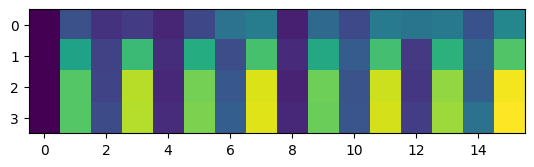

In [7]:
plt.imshow(conductance_values.reshape(12, 16)[:4])

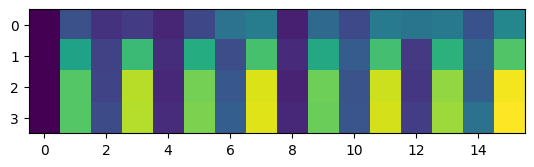

In [8]:
plt.imshow(conductance_values[0])

(12, 12)


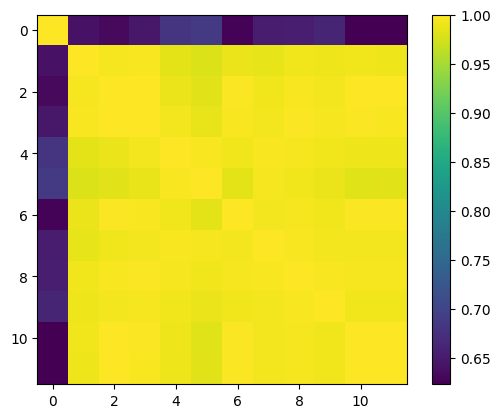

In [9]:
corr_matrix = np.corrcoef(conductance_values.reshape((12, 16)))

print(corr_matrix.shape)  # Output: (12, 12)
plt.imshow(corr_matrix)
plt.colorbar()
plt.show()

In [10]:
df = pd.read_excel("data\Two_mask_sets_metrics_extended.xlsx")

In [11]:
masks = [f"{colour} {intensity}" for colour in ['White', '365nm', '455nm'] for intensity in ['I1', 'I2', 'I3', 'I4']]

In [17]:
df[(df['First Mask'] == masks[0]) & (df['Second Mask'] == masks[1])]['Accuracy'].iloc[0]

0.9079747804957248

In [18]:
accuracies = np.zeros((12, 12))
for i in range(len(masks)):
    for j in range(len(masks)):
        mask1, mask2 = masks[i], masks[j]
        accuracies[i][j] = df[(df['First Mask'] == mask1) & (df['Second Mask'] == mask2)]['Accuracy'].iloc[0]


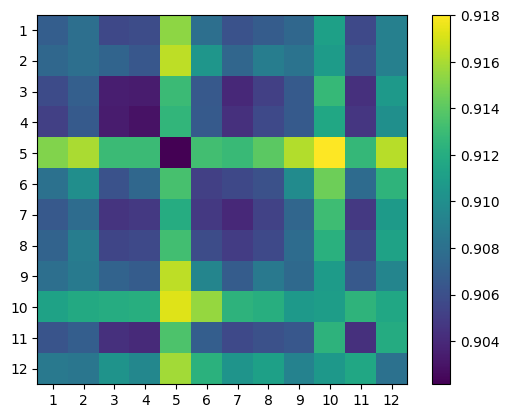

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the heatmap
plt.imshow(accuracies, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a color scale

# Set the axis ticks to start from 1 instead of 0
plt.xticks(ticks=np.arange(12), labels=np.arange(1, 13))  # X-axis labels from 1 to 12
plt.yticks(ticks=np.arange(12), labels=np.arange(1, 13))  # Y-axis labels from 1 to 12

plt.show()


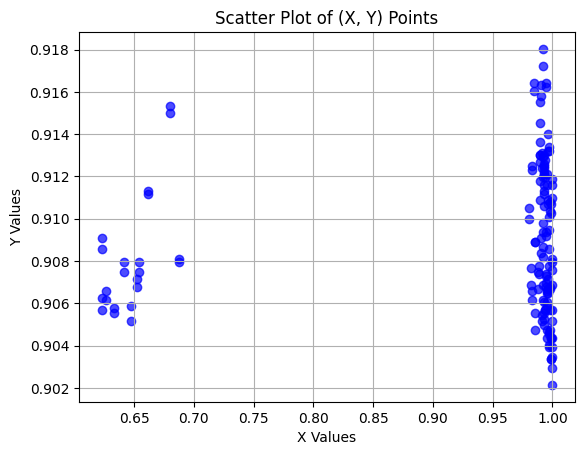

In [22]:

# Flatten the (12, 12) arrays into 1D arrays
x_flat = corr_matrix.flatten()
y_flat = accuracies.flatten()

# Plot the scatter plot
plt.scatter(x_flat, y_flat, c='blue', marker='o', alpha=0.7)  # 'c' sets color, 'alpha' sets transparency
plt.xlabel("X Values")
plt.ylabel("Y Values")
plt.title("Scatter Plot of (X, Y) Points")
plt.grid(True)

plt.show()

In [25]:
correlation_values = pd.DataFrame({"correlation":corr_matrix.flatten(), "accuracies":accuracies.flatten()})
correlation_values.to_excel("data/Accuracies_vs_correlation_between_masks.xlsx")

In [29]:
correlation_df = pd.DataFrame(corr_matrix, index=masks, columns=masks)
correlation_df.to_excel("data/Pearsons_correlation_matrix.xlsx")

In [32]:
accuracies_df = pd.DataFrame(accuracies, index=masks, columns=masks)
accuracies_df.to_excel("data/accuracies_matrix.xlsx")

In [42]:
df[(df['First Mask'] == "White I1") & (df['Second Mask'] == "White I2")]['Accuracy'].iloc[0]

0.9085647353022929